### Function Imports

In [1]:
import numpy as np
%pylab 
rcParams['figure.figsize'] = 12,8
from numba import jit
import random

import copy
import networkx as nx

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Random Matrix Generation Functions

In [2]:
def getRandomConnectivity(N, pct_connected):
    ''' 
    Function that generates an adjacency matrix for an N neuron network.
    
    Inputs: 
        (int) N: Number of neurons in network
        (float) pct_connected: percent chance for two neurons to connect to one another
        
    Outputs: 
        (2dArray(int)) M: Adjacency Matrix
    '''
    M = np.random.rand(N**2).reshape(N,N)
    for i in range(N):
        for j in range(N):
            if (i == j):
                M[i,j] = 0
            else:
                if (M[i,j] < pct_connected):
                    M[i,j] = 1 #i connects to j
                else:
                    M[i,j] = 0
    return M

### Graph theoretic functions to explore role of $k$-cores in network dynamics

In [3]:
def hasKcore(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            
            return False
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return True
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)

            
# TODO get Kcore indices 

def largestKcore(M):
    '''
    Function largestKcore: Returns largest k-value kcore in network M
    
    Inputs:
        (2dArray(int)) M: Adjacency Matrix 
        
    Outputs: 
        (int) k-1: largest k-value kcore in the network
    '''
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    while (hasKcore(M,k)):
        k = k+1
        
    return k - 1
        
    
    
def largestkcore(M):
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    s=1
    while (s==1):
        
        X = M.copy()
        while(True):
            cur_num_nodes = X.shape[0]
            s = np.sum(X, 0)
            nodes_to_delete = np.where(s < k)[0]
            if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
            
                s=0
                break
            elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
                s=1
                break
            else:
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
        k = k+1
        
    return k - 1

#TODO: Instead of deleting nodes, put 0's on all the connections for the rows and columns that are disconnected
    #Keeps number of all neurons the same so that neuron 3 doesnt become neuron 2 etc. 
    #Look for neurons not in Kcore which are firing and neurons that are in kcore and not firing. 
def kcoreitself(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            # nothing has at least k connections
            return X
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return X
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)



#here we get the largest connected component of  the graph

def largestcomponent(l,N):
    n=np.random.randint(0,N)
    
    boundary=[n]
    b=1
    comp=[n]
    c=1
   
    while(b>0):
        a=boundary.pop()
        
        oldvertex=int(a)
        
        deg=l[oldvertex,0]
        degree=int(deg)
        #print(degree)
        for j in range(degree):
            newvertex=l[oldvertex,j+1]
            q=comp.count(newvertex)
            #print(newvertex)
            q=int(q)
            #print(q)
            if (q==0):
                comp.append(newvertex)
                boundary.append(newvertex)
                #print(newvertex)
                #print(boundary)
            
        b=len(boundary)
            
    #sizeofcomp=len(comp)
    return(comp)

def matrixOfEdges(M,N):
    '''
    Function matrixOfEdges: Returns edgelist from adjacency matrix as 2d numpy array 
    
    Inputs: 
        (2dArray(int)) M: Adjacency Matrix
        (int) N: number of neurons in network, or length of one axis of M
        
    Outputs: 
        (2dArray(int)) E: Edge list of neuronal network. 
    '''
    N = int(N)
    E=np.zeros(N**2).reshape(N,N)  #prepare array with zeros
    k=np.sum(M,0) #array with degree of each vertex
    for i in range(N):
        a=int(k[i]) #degree of the current vertex
        E[i,0]=a  #we put it to the zero row of matrix of edges
    for i in range(N):
        a=int(k[i])
        q=1
        for j in range(N):
            if (M[j,i]==1):
                E[i,q]=j #all the next elements in current column are number of vertices current vertex is connected to
                q=q+1
    return(E)

### Chaos Classifier

In [4]:
def cut(C): 
    return C[int(0.9*len(C)):] #we take the second half of the time, when trajectory is close to SO, H,Q or chaos

def deriv(X):  #just a derivative
    N=len(X)
    if N == 0: 
        return []
    d=zeros(N-1)
    for i in range(N-1):
        d[i]=X[i+1]-X[i]
    return d

def muldev(X): #it is like a derivative but multiplication instead of difference
    N=len(X)
    md = zeros(N-1)
    for i in range(N-1):
        md[i]=X[i+1]*X[i]
    return md

def classifier(C1, timetolerance, Ctolerance):
    '''
    Function classifier: Returns classification of network dynamics. 1 is SO, 0 is chaos, 2 is Fixed point, -1 is error
    
    Inputs: 
        (1dArray(float)) C1: 
        (float) timetolerance: 
        (float) Ctolerance: 
        
    Outputs: 
        (int) checker: Classification of network behavior as defined above. 
    '''
    C=cut(C1) #we look at the second half when it closer to the cycle or whatever it is
    N=len(C)
    countermax=0
    countermin=0
    Cprime=deriv(C)
    Cmd=muldev(Cprime)
    Cpp = deriv(Cprime)
    for i in range(N-2):
        if (Cmd[i]<0): #if sign of derivative changes it means that it max or min
            if (Cpp[i]>0): #if second derivative > 0 it is min
                countermin=countermin+1
            else:
                countermax=countermax+1 # else it is max
    
    max_C = max(C[int(.75*N):N])
    min_C = min(C[int(.75*N):N])
    
    #print(max_C, ",", min_C)
    
    if ((max_C - min_C) < Ctolerance):
        return 2
    
    if ((countermin == 0) and (countermax == 0)):
        return 2
    
    maximums=np.zeros(countermax)
    minimums=np.zeros(countermin)
    maxtimes=np.zeros(countermax)
    mintimes=np.zeros(countermin)
    qmax=0 #counter of max
    qmin=0 #counter of min
    for i in range(N-2):
        if (Cmd[i]<0):
            if (Cpp[i]>0):
                mintimes[qmin]=i #the time when min occurs
                minimums[qmin]=C[i] #the value
                qmin=qmin+1 
            else:
                maxtimes[qmax]=i #the same story for max
                maximums[qmax]=C[i]
                qmax=qmax+1
    
    ### Mihai ~ ADDED TEMPORARY MAGIC NUMBERS TO FIX OFF BY 1 ### 
    min_dim = min(len(maxtimes),len(mintimes))
    maxtimes = maxtimes[:min_dim]
    mintimes = mintimes[:min_dim]
    
    minperiods=deriv(mintimes)
    maxperiods=deriv(maxtimes)
    #print(minperiods)
    #print(maxperiods)

    if(len(maxtimes)+len(mintimes)-2 < 2):  #if the period is too long #Mihai ~ Changed to .any(), but formulation is ambiguous
        print('Increase observation time N*dt')
        return(-1) #-1 is error 
    
    
    checker=1    #we will check conditions for this stuff to be cycle, not chaos. If at lest one of them fails, we put checker to 0
    avper=(sum(minperiods)+sum(maxperiods))*1.0/(countermin+countermax-2) #average period
    #print(avper)
    #print(minimums)
    #print(maximums)
    avmin=sum(minimums)*1.0/countermin #average value of minimum
    avmax=sum(maximums)*1.0/countermax #average value of maximum
    if (avmax-avmin<Ctolerance):
        return(2) #if the difference between min and max smaller than tolerance it is fixed point
    #for i in range(countermin-1):
    for i in range(countermin-2):
        if (abs(minperiods[i]-avper)>timetolerance): #if the deviation from the average larger than the tolerance
            checker=0 #than it is not SO
    #for i in range(countermax-1):
    for i in range(countermax-2):
        if (abs(maxperiods[i]-avper)>timetolerance):
            checker=0
    for i in range(countermin):
        if (abs(minimums[i]-avmin)>Ctolerance):
            checker=0
    for i in range(countermax):
        if (abs(maximums[i]-avmax)>Ctolerance):
            checker=0
    return(checker) #1 is SO, 0 is chaos. 2 is fixed point. -1 is error. 

### Non-chaos Classifier (faster classification but cannot distinguish chaos phase) 

In [5]:
def classify(V, params):
    '''
    Function classify: Returns classification of network dynamics. 1 is stable oscillation, 2 is quiescent fixed point, 3 is high activity fixed point
    
    Inputs: 
        (1dArray(float)) V: Array of voltages or calcium concentrations representing network dynamics for one parameter set
        (1dArray(float)) params: Array of network parameters 
        
    Outputs: 
        (int) classification: Returns classification of network dynamics as defined above. 
    '''
    #Set up some globals 
    
    N = int(params[0])
    n = int(params[1])
    
    #Network uniformly connected but vectorized lets us scale later 
    #for i in range (N/2, N):
    #max_V = max(V[int(N/2):N])
    #min_V = min(V[int(N/2):N])
    max_V = max(V[int(.9*N):N])
    min_V = min(V[int(.9*N):N])
   
            
    V_delta = max_V - min_V
    #print(V_delta)
    
    if V_delta < 0.001: #changed from 1
        if V[N-1] < 15:
            #params[12] = 2
            return 2
        else:
            #params[12] = 3
            return 3
    else:
        #params[12] = 1
        return 1
        
def classify2(V, params):
    '''
    Function classify2: Returns classification of network dynamics. 1 is stable oscillation across V* boundary, 
                        2 is quiescent fixed point, 3 is high activity fixed point, 4 is stable oscillation where
                        network oscillates above V* boundary, 5 is stable oscillation where network oscillates 
                        below V* boundary.
    
    Inputs: 
        (1dArray(float)) V: Array of voltages or calcium concentrations representing network dynamics for one parameter set
        (1dArray(float)) params: Array of network parameters 
        
    Outputs: 
        (int) classification: Returns classification of network dynamics as defined above. 
    '''
    #Set up some globals 
    
    N = int(params[0])
    n = int(params[1])
    
    #Network uniformly connected but vectorized lets us scale later 
    #for i in range (N/2, N):
    max_V = max(V[int(N/2):N])
    min_V = min(V[int(N/2):N])
   
            
    V_delta = max_V - min_V
    
    if V_delta < 0.1: #changed from 1
        if V[N-1] < params[5]:
            #params[12] = 2
            return 2
        else:
            #params[12] = 3
            return 3
    else:
        if max_V > params[5] and min_V < params[5]:
            return 1
        if max_V > params[5] and min_V > params[5]:
            return 4
        if max_V < params[5] and min_V < params[5]:
            return 5

### Dynamics Simulation Functions

In [6]:
@jit(nopython=True)
def step_mf_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r_1 = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    
    firing_neurons_count = zeros(N*n).reshape(N,n) #Individually count how may neurons are actually firing in this model at a given step N.
    
    avV=zeros(N) #average potential
    avC=zeros(N)  #average calcium
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0
        if V[0,i] > Vstar: #keep track of and return how many neurons in the network are actually firing  
            firing_neurons_count[0,i] = 1
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    
    for i in range(N - 1): 
        for j in range(n):
            if V[i,j] > Vstar: 
                r = r_1
            else:
                # Set r = r_0 if offset is used
                r = r_0

            if C[i,j] < Cstar: 
                dV = delV 
            else: 
                dV = 0

            V[i+1,j] = (-V[i,j]/tauv + (n-1)*dV*(r + r_0)) * dt + V[i,j]
            if V[i+1,j] > Vstar: 
                firing_neurons_count[i+1,j] = 1
            C[i+1,j] = (-C[i,j]/tauc + (n-1)*delC*(r + r_0)) * dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
            
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n    
    
    return avC, avV, firing_neurons_count

@jit(nopython=True)
def sigmoid_mf_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N)
    
    #avV=zeros(N) #average potencial
    #avC=zeros(N)  #average calcium
    
    for i in range(n):
        V[0]=V0 #initial conditions
        C[0]=C0 
        #avV[0]=n*V0
        #avC[0]=n*C0

    for i in range(N-1):
        V[i+1] = (-V[i]/tauv + (1/(1+exp((C[i]-Cstar)/g_c))) * p * (n-1) * (r/(1+exp((Vstar-V[i])/g_v)) + r_0)) * dt + V[i]
        C[i+1] = (-C[i]/tauc + delC * p * (n-1) * (r/(1+exp((Vstar-V[i])/g_v)) + r_0)) * dt + C[i]
        #avC[i+1]=avC[i+1]+C[i+1]
        #avV[i+1]=avV[i+1]+V[i+1]
            
    #avC /= n
    #avV /= n
            
    return(C, V)

@jit(nopython=True)
def step_hetero_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r_1 = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    #P=zeros(n)  # function P(V), sigmoid
    P = zeros(N*n).reshape(N,n)
    deltaV=zeros(n)
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    firing_neurons_count = zeros(N*n).reshape(N,n) #Individually count how may neurons are actually firing in this model at a given step N.
    
    for i in range(n):
        V[0,i]= np.random.uniform(0, 2*Vstar)#V0 #initial conditions
        C[0,i]= np.random.uniform(Cstar - 0.5, Cstar + 0.5)#C0 
        if V[0,i] > Vstar: #keep track of and return how many neurons in the network are actually firing  
            firing_neurons_count[0,i] = 1
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            if (V[i,j]>Vstar): #V[i,j] stores voltage of each neuron instead of returning the average voltage 
                P[i,j]=r_1+r_0
            else:
                P[i,j]=r_0
                
            if (C[i,j]<Cstar):
                deltaV[j]=delV #change from 1.2 
            else:
                deltaV[j]=0#delVmin #changed from .4
        for j in range(n):
            a=int(l[j,0]) #a should give number of firing neighbors 
            for k in range(a):
                b = int(l[j,k+1])
                sump[j]=sump[j]+P[i,b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + deltaV[j]*sump[j])*dt + V[i,j]
            if V[i+1,j] > Vstar: 
                firing_neurons_count[i+1,j] = 1 #used to return count of firing neurons later
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
    return(avC,avV, firing_neurons_count, P, V, C)

@jit(nopython=True)
def sigmoid_hetero_dyn(M,l,params):
    N = int(params[0])
    n = int(params[1])
    dt = params[2]
    tauv = params[3]
    tauc = params[4]
    Vstar = params[5]
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r = params[9]
    V0 = params[10]
    C0 = params[11]
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    #res = int(params[12]) #resulting classification 
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            sump[j]=0
        for j in range(n):
            P[j] = (r - r_0)/(1+exp((Vstar-V[i,j])/g_v)) + r_0
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + delV*sump[j]*(1/(1+exp((C[i,j]-Cstar)/g_c))) )*dt + V[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        #for j in range(n):
        #    sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
   
    #return(avC,avV,C,V)
    return(avC,avV,C,V,sump)

### Network Definition

In [7]:
class Network: 
    def __init__(self, M, l, params):
        self.M_init = M
        self.l_init = l 
        self.M = M
        self.l = l
        self.params = params
        self.N = int(params[0])
        self.n_init = int(params[1])
        self.n = int(params[1])
        self.dt = params[2]
        self.tauv = params[3]
        self.tauc = params[4]
        self.Vstar = params[5]
        self.Cstar = params[6]
        self.delV = params[7]
        self.delC = params[8]
        self.r = params[9]
        self.V0 = params[10]
        self.C0 = params[11]
        self.g_v = params[12]
        self.g_c = params[13]
        self.r_0 = params[14]
        self.n_edges = np.sum(self.l[:,0])
        self.kill_order = []
        
    def kill_neuron(self):
        x = 1
        self.n -= 1
        self.params[1] = self.n
        self.M = np.delete(self.M,x,axis=0)
        self.M = np.delete(self.M,x,axis=1)
        #self.M[x] = np.zeros(self.n_init)
        #self.M[:,x] = np.zeros(self.n_init)
        self.l = matrixOfEdges(self.M, self.n)
        
    def kill_neuron2(self, n):
        x = 0
        for i in range(int(n)):
            self.M = np.delete(self.M, x, axis=0)
            self.M = np.delete(self.M, x, axis=1)
        self.n -= n
        self.params[1] = self.n
        self.l = matrixOfEdges(self.M, self.n)

    def killEdge(self):
        l_copy = copy.deepcopy(self.l)
        
        non_zero_rows = []
        
        for i in range(self.n):
            if l_copy[i,0] != 0:
                non_zero_rows.append(i)
            # Experimental removal of neurons as all incoming edges are killed 
            #else:
            #    self.n -= 1
            
        
        #randomly pick a row that has some connections
        if len(non_zero_rows) == 0:
            return False
        
        row_idx = random.randint(0,len(non_zero_rows) - 1)
        row = non_zero_rows[row_idx]
        
        if l_copy[row,0] == 0:
            self.l = l_copy
            return False
        
        else: 
            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]
            
            #remove entry and roll array 
            row_reinsert[edge_idx] = 0
            
            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert
            
            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            return True
        
    def killEdge2(self, n):
        for i in range(n): 
            l_copy = copy.deepcopy(self.l)
        
            non_zero_rows = []

            for j in range(self.n):
                if l_copy[j,0] != 0:
                    non_zero_rows.append(j)
                    
            row = non_zero_rows[self.kill_order[i][0]]
            
        
            #randomly pick edge
            edge_idx = self.kill_order[i][1]
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
        
    def init_kill_order(self):
        while True:
            l_copy = copy.deepcopy(self.l)

            non_zero_rows = []

            for i in range(self.n):
                if l_copy[i,0] != 0:
                    non_zero_rows.append(i)
                # Experimental removal of neurons as all incoming edges are killed 
                #else:
                #    self.n -= 1


            #randomly pick a row that has some connections
            if len(non_zero_rows) == 0:
                #reset initial values 
                self.M = self.M_init
                self.l = self.l_init
                self.n_edges = np.sum(self.l_init[:,0])
                break

            row_idx = random.randint(0,len(non_zero_rows) - 1)
            row = non_zero_rows[row_idx]

            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            self.kill_order.append((row_idx, edge_idx))
     
    # TODO: FINISH
    def simdyn(self, M, l, params, connectivity="heterogeneous", activation="sigmoid"):
        if connectivity ==  "mean field" and activation == "step":
            return step_mf_dyn(self.M, self.l, self.params)
        elif connectivity ==  "mean field" and activation == "sigmoid":
            return sigmoid_mf_dyn(self.M, self.l, self.params)
        elif connectivity == "heterogeneous" and activation == "step":
            return step_hetero_dyn(self.M, self.l, self.params)
        elif connectivity == "heterogeneous" and activation == "sigmoid":
            return sigmoid_hetero_dyn(self.M, self.l, self.params)
        else:
            print("!!! Check network type and activation function !!!")
            
        #return simDynamics(self.M, self.l, self.params)

### Simulation of network dynamics for select parameters

In [31]:
# Setup simulation parameters 
n = 100
p = 1/2
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [11]:
#mean field step function limit
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 8. #1.
delVmin = delV/3 #delV/3
delC= 0.035 #0.01
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)


C,V,f = network.simdyn(network.M, network.l, network.params, connectivity="mean field", activation="step")

In [16]:
# Setup simulation parameters 
n = 15
p = 1/2
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [31]:
#Heterogeneous sigmoid 
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5. #1.
delVmin = delV/3 #delV/3
delC= 0.025 #0.01
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)

avC,avV,C,V,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous", activation="sigmoid")

In [37]:
V[-1]

array([ 2.4715868 , 30.29399066, 35.68310282, 38.65606584,  2.92852859,
       39.93949627, 31.81629863, 15.21494473,  6.93634071, 12.29306525,
        9.92702531, 13.38448508,  2.25647126, 23.36626678,  2.47562946])

2


Text(0, 0.5, 'V')

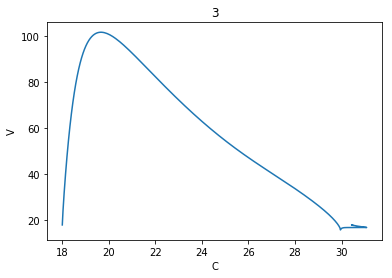

In [32]:
print(classifier(avV, 1/dt, 0.1)) #0 is chaos, 1 is SO, 2 is FP, -1 is error
plot(avC[:],avV[:])
title(classify(avV,params))
xlabel("C")
ylabel("V")

# Phase Diagrams

Phase Diagrams for network dynamics exist in two flavors: 
1. Boundary Tracing
    - Optimal for getting a rough sketch of phase boundary. 
    - Sensitive to unexpected behavior of heterogeneously connected network.
2. Color mapping 
    - Optimal for completely mapping out phase space of possible dynamics.
    - Slower. Not all of the phase space is interesting. 

### Heterogeneous connectivity, Sigmoid activation

In [8]:
n = 100
p = 1/2
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [9]:
N=10000
dt=0.01 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 1. #1.
delVmin = delV/3 #delV/3
delC= 0.025 #0.01
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

dV = 0.1
delVmax = 25.

V_space = np.arange(delV, delVmax, dV)
n_space = np.arange(2,n+1)

phase = np.zeros((len(n_space), len(V_space)))

network = Network(M, l, params)

for i in reversed(range(len(n_space))):
    #M_prime = copy.deepcopy(M)
    #l_prime = copy.deepcopy(l)
    #params[1] = n
    network.M = network.M_init
    network.l = network.l_init
    network.params[1] = n
    network.n = n
    
    if (network.n - n_space[i]) > 0:
        #import pdb; pdb.set_trace()
        #network.params[1] = n_space[i]
        #network.n = n_space[i]
        network.kill_neuron2(network.n-n_space[i])
    for j in range(len(V_space)):
        #import pdb; pdb.set_trace()
        network.params[7] = V_space[j]
        C,V,c_arr,v_arr,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous",
                                             activation="sigmoid")
        check = classify2(V,params)
        phase[i,j] = check
    print("Visited n = {}".format(i))

print('loop complete')

Visited n = 98
Visited n = 97
Visited n = 96


KeyboardInterrupt: 

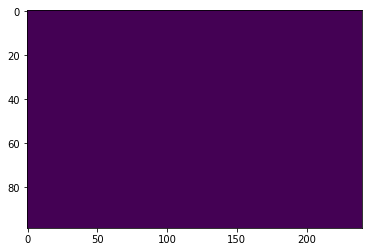

In [61]:
cmap = plt.cm.viridis
data = np.flip(phase, axis=0)
norm = plt.Normalize(vmin = data.min(), vmax = data.max())
img = cmap(norm(data))
imshow(img, aspect='auto')

# Network Connectivity plots for small samples

### Heterogeneously connected, sigmoid activation 

In [153]:
# Setup simulation parameters 
n = 15
p = 1/6
M = getRandomConnectivity(n, p)
l = matrixOfEdges(M, n)

In [154]:
#Heterogeneous sigmoid 
N = 20000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 4. #1.
delVmin = delV/3 #delV/3
delC= 0.025 #0.01
r_1= 70*99/(n-1)#Max Firing rate is r_1 + r_0 70
r_0 = 5*99/(n-1) #Min firing rate 5

g_v = 5
g_c = 5

params = np.zeros(15)

params[0] = int(N)
params[1] = int(n)
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r_1
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M, l, params)

avC,avV,C,V,sump = network.simdyn(network.M, network.l, network.params, connectivity="heterogeneous", activation="sigmoid")

2


Text(0, 0.5, 'V')

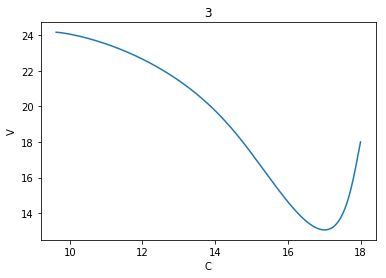

In [155]:
print(classifier(avV, 1/dt, 0.1)) #0 is chaos, 1 is SO, 2 is FP, -1 is error
plot(avC[:],avV[:])
title(classify(avV,params))
xlabel("C")
ylabel("V")

In [156]:
G = nx.DiGraph()
for i in range(n): 
    if  V[-1, i] > Vstar:
        G.add_node(i, color='r', firing=True)
    else:
        G.add_node(i, color='k', firing=False)
        
for i in range(n): 
    for j in range(n): 
        if network.M[i,j] == 1: 
            G.add_edge(i,j)

In [157]:
clist = np.zeros(15, dtype=str)
for i in range(n):
    color = G.nodes.data()[i]['color']
    clist[i] = color


In [158]:
clist

array(['r', 'r', 'r', 'r', 'k', 'r', 'r', 'r', 'r', 'r', 'r', 'k', 'r',
       'r', 'r'], dtype='<U1')

In [159]:
G.degree

DiDegreeView({0: 6, 1: 4, 2: 3, 3: 4, 4: 2, 5: 7, 6: 3, 7: 5, 8: 2, 9: 5, 10: 5, 11: 4, 12: 3, 13: 4, 14: 3})

In [151]:
V[-1,:]


array([28.28247195, 17.58044977, 32.09358259, 12.4177842 , 12.4177842 ,
       34.99383666, 32.08937449, 34.96971976, 30.6960937 , 35.1035715 ,
       34.70709961, 34.99510853, 34.88943131, 32.09358259, 31.96625843])

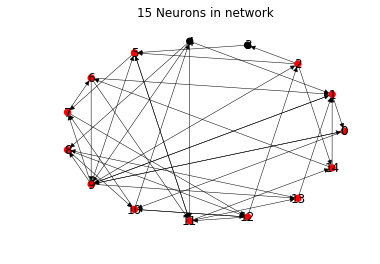

In [152]:
plt.title("%d Neurons in network"%G.order())
nx.draw_circular(G, node_size=40, width=0.5, with_labels=True, node_color=clist)
#nx.draw_circular(G,node_size=20,width=0.5,edge_color='black',node_color='black',with_labels=True)
#nx.draw_circular(H,node_size=20,width=0.3,node_color='black', edge_color='black')


### Heterogeneously connected, step function activation